In [1]:
# IMPORTS
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
%matplotlib inline
import numpy as np
import pandas as pd
import time as time
import sys

## Import data

In [2]:
# READ DATA
tic = time.time()

# Import thick detector data
fname_thick = 'Tracking_1e5n_CutGas10um_CutSolid50nm_SymmetricDeposition_09umMylar.txt';
data_detThick = pd.read_csv(
    fname_thick,
    names=['eventID', 'det', 'PID', 'E', 'xpos', 'ypos', 'zpos', 'dE', 'dx', 'dy','dz', 'dr','dx_cum', 'dy_cum','dz_cum', 'dr_cum'],
    usecols=[0,1,2,3,4,5,6,7,8,11,12,15],
    sep='\t');



# Import coincidence detector data
data_detCoinc = data_detThick; # Uncomment if data file for coinc and thick detector is the same, instead of importing new file

# fname_coinc = 'Tracking_1e6n_CutGas10um_CutSolid50nm_SymmetricDeposition_09umMylar.txt';
# data_detCoinc = pd.read_csv(fname_coinc,
#                 names=['eventID', 'det', 'PID', 'E', 'xpos', 'ypos', 'zpos', 'dE', 'dx', 'dy','dz', 'dr','dx_cum', 'dy_cum','dz_cum', 'dr_cum'],
#                 usecols=[0,1,2,3,4,5,6,7,8,11,12,15],
#                 sep='\t');


print('Time Elapsed: ' + str(np.round(time.time()-tic,2)) + ' s')

Time Elapsed: 1.85 s


## Create data arrays by detectors and particles

In [3]:
tic = time.time()

E_threshold = 100 #keV
N_neutrons = np.power(10,np.ceil(np.log10(data_detThick['eventID'].iloc[-1]+1))) #get number of incident neutrons from last eventID

#--- DET THICK ---# 
det_thick = data_detThick.loc[(data_detThick['det']=='A')]
events_below_threshold = np.array(det_thick['eventID'].loc[(det_thick['dr_cum']==0) & (det_thick['E']<E_threshold)])
det_thick = det_thick.loc[~(det_thick['eventID'].isin(events_below_threshold))]
events_det_thick,events_det_thick_idx = np.unique(det_thick.loc[:,'eventID'],return_index=True);

#--- Det thick, alpha particle ---# 
det_thick_alpha = det_thick.loc[det_thick['PID']=='alpha']
events_det_thick_alpha,events_det_thick_alpha_idx = np.unique(det_thick_alpha.loc[:,'eventID'],return_index=True);

#--- Det thick, Li particle ---# 
det_thick_Li = det_thick.loc[det_thick['PID']=='Li7']
events_det_thick_Li,events_det_thick_Li_idx = np.unique(det_thick_Li.loc[:,'eventID'],return_index=True);


#--- DET COINC ---# 
#--- Det A ---# 
detA = data_detCoinc.loc[(data_detCoinc['det']=='A')]
events_below_threshold = np.array(detA['eventID'].loc[(detA['dr_cum']==0) & (detA['E']<E_threshold)])
detA = detA.loc[~(detA['eventID'].isin(events_below_threshold))]
events_detA,events_detA_idx = np.unique(detA.loc[:,'eventID'],return_index=True);

#--- Det A, alpha particle ---# 
detA_alpha = detA.loc[detA['PID']=='alpha']
events_detA_alpha,events_detA_alpha_idx = np.unique(detA_alpha.loc[:,'eventID'],return_index=True);

#--- Det A, Li particle ---# 
detA_Li = detA.loc[detA['PID']=='Li7']
events_detA_Li,events_detA_Li_idx = np.unique(detA_Li.loc[:,'eventID'],return_index=True);

#--- Det B ---# 
detB = data_detCoinc.loc[(data_detCoinc['det']=='B')]
events_below_threshold = np.array(detB['eventID'].loc[(detB['dr_cum']==0) & (detB['E']<E_threshold)])
detB = detB.loc[~(detB['eventID'].isin(events_below_threshold))]
events_detB,events_detB_idx = np.unique(detB.loc[:,'eventID'],return_index=True);

#--- Det B, alpha particle ---# 
detB_alpha = detB.loc[detB['PID']=='alpha']
events_detB_alpha,events_detB_alpha_idx = np.unique(detB_alpha.loc[:,'eventID'],return_index=True);

#--- Det B, Li particle ---# 
detB_Li = detB.loc[detB['PID']=='Li7']
events_detB_Li,events_detB_Li_idx = np.unique(detB_Li.loc[:,'eventID'],return_index=True);

#--- Det Coinc ---# 
detCoinc = data_detCoinc.loc[data_detCoinc['eventID'].isin(events_detA) & data_detCoinc['eventID'].isin(events_detB)]
events_coinc,events_coinc_idx = np.unique(detCoinc.loc[:,'eventID'],return_index=True);

detA_coinc = detCoinc.loc[detCoinc['det']=='A']
events_coinc_detA,events_coinc_detA_idx = np.unique(detA_coinc.loc[:,'eventID'],return_index=True);

detB_coinc = detCoinc.loc[detCoinc['det']=='B']
events_coinc_detB,events_coinc_detB_idx = np.unique(detB_coinc.loc[:,'eventID'],return_index=True);

events_coinc_detA_alpha = np.intersect1d(events_detA_alpha,events_detB_Li)
events_coinc_detA_Li = np.intersect1d(events_detA_Li,events_detB_alpha)


print('\n------ Thick Detector ------\n')
N_events = len(np.unique(np.concatenate((det_thick_alpha['eventID'],det_thick_Li['eventID']))))
print(str(N_events) + ' total neutron captures detected:')
print('\t'+ str(len(events_det_thick_alpha)) + ' (' + str(np.round(len(events_det_thick_alpha)/N_neutrons*100,2)) + '%) -> \u03B1 particles on det A')
print('\t'+ str(len(events_det_thick_Li)) + ' (' + str(np.round(len(events_det_thick_Li)/N_neutrons*100,2)) + '%) -> \u2077Li particles on det A')
print('\n Detection efficiency:    ' + str(np.round(N_events/N_neutrons*100,2)) + '%')


print('\n\n\n------ Coincidence Detector ------\n')
N_events = len(np.unique(np.concatenate((detA_alpha['eventID'],detA_Li['eventID'],detB_alpha['eventID'],detB_Li['eventID']))))
print(str(N_events) + ' total neutron captures detected:')
print('\t'+ str(len(events_detA_alpha)) + ' (' + str(np.round(len(events_detA_alpha)/N_neutrons*100,2)) + '%) -> \u03B1 particles on det A')
print('\t'+ str(len(events_detA_Li)) + ' (' + str(np.round(len(events_detA_Li)/N_neutrons*100,2)) + '%) -> \u2077Li particles on det A')
print('\t'+ str(len(events_detB_alpha)) + ' (' + str(np.round(len(events_detB_alpha)/N_neutrons*100,2)) + '%) -> \u03B1 particles on det B')
print('\t'+ str(len(events_detB_Li)) + ' (' + str(np.round(len(events_detB_Li)/N_neutrons*100,2)) + '%) -> \u2077Li particles on det B')
print('\n'+ str(len(events_coinc)) + ' coincidental neutron captures:')
print('\t'+ str(len(events_coinc_detA_alpha)) + ' (' +str(np.round(len(events_coinc_detA_alpha)/N_neutrons*100,2)) + '%) -> \u03B1 on det A + \u2077Li on det B')
print('\t'+ str(len(events_coinc_detA_Li)) + ' (' +str(np.round(len(events_coinc_detA_Li)/N_neutrons*100,2)) + '%) -> \u2077Li on det A + \u03B1 on det B')
print('\n Total det efficiency:    ' + str(np.round(N_events/N_neutrons*100,2)) + '%')
print(' Coincidental efficiency: ' + str(np.round(len(events_coinc)/N_neutrons*100,2)) + '%')

N_captures = 'total';
print('\nTime Elapsed: ' + str(np.round(time.time()-tic,2)) + ' s')

del data_detCoinc
del data_detThick


------ Thick Detector ------

2562 total neutron captures detected:
	1588 (1.59%) -> α particles on det A
	974 (0.97%) -> ⁷Li particles on det A

 Detection efficiency:    2.56%



------ Coincidence Detector ------

3686 total neutron captures detected:
	1588 (1.59%) -> α particles on det A
	974 (0.97%) -> ⁷Li particles on det A
	1560 (1.56%) -> α particles on det B
	947 (0.95%) -> ⁷Li particles on det B

1381 coincidental neutron captures:
	689 (0.69%) -> α on det A + ⁷Li on det B
	692 (0.69%) -> ⁷Li on det A + α on det B

 Total det efficiency:    3.69%
 Coincidental efficiency: 1.38%

Time Elapsed: 1.56 s


### Limit neutron captures


In [4]:
# Uncoment lines below to use only a defined number of neutron caputres

# # N_captures = len(events_coinc)
# N_captures = 1000

# events_det_thick = events_det_thick[:int(N_captures)]
# events_det_thick_idx = events_det_thick_idx[:int(N_captures)]
# events_coinc = events_coinc[:N_captures]
# events_coinc_detA = events_coinc_detA[:N_captures]
# events_coinc_detA_idx = events_coinc_detA_idx[:N_captures]

# events_coinc_detB = events_coinc_detB[:N_captures]
# events_coinc_detB_idx = events_coinc_detB_idx[:N_captures]


# det_thick = det_thick.loc[det_thick['eventID'].isin(events_det_thick)]
# detA_coinc = detA_coinc.loc[detA_coinc['eventID'].isin(events_coinc_detA) ]
# detB_coinc = detB_coinc.loc[detB_coinc['eventID'].isin(events_coinc_detB) ]

### Position reconstruction by energy weighted average and gaussian fit

det Thick --> x = 0.00331 mm
      --> FWHM = 2.7766 mm (R² = 0.9324)

det Coinc --> x = -0.00554 mm
	--> FWHM = 0.2774 mm (R² = 0.9894)

 Improvement Factor: FWHM(thick) / FWHM(coinc) = 10.01


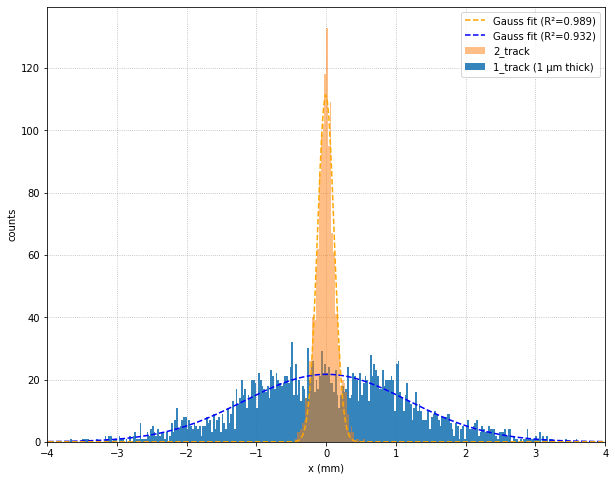

In [5]:
## tic = time.time()

# ----- x position reconstruction: Det Thick ----- #
xpos_aux = det_thick[['eventID','dE','xpos']].copy()
xpos_aux['xpos_weighted'] = xpos_aux['dE'] * xpos_aux['xpos']/1e3
xpos_det_thick = xpos_aux.groupby('eventID')['xpos_weighted'].sum() / xpos_aux.groupby('eventID')['dE'].sum()

# ----- x position reconstruction: Det Coinc ----- #
xpos_aux = detA_coinc[['eventID','dE','xpos']].copy()
xpos_aux['xpos_weighted'] = xpos_aux['dE']* xpos_aux['xpos']/1e3
xpos_detA_coinc = xpos_aux.groupby('eventID')['xpos_weighted'].sum() / xpos_aux.groupby('eventID')['dE'].sum()

E_detA_coinc = np.array(detA_coinc.iloc[events_coinc_detA_idx]['E']) - np.array(detA_coinc.groupby('eventID')['E'].last())

xpos_aux = detB_coinc[['eventID','dE','xpos']].copy()
xpos_aux['xpos_weighted'] = xpos_aux['dE']* xpos_aux['xpos']/1e3
xpos_detB_coinc = xpos_aux.groupby('eventID')['xpos_weighted'].sum() / xpos_aux.groupby('eventID')['dE'].sum()

E_detB_coinc = np.array(detB_coinc.iloc[events_coinc_detB_idx]['E']) - np.array(detB_coinc.groupby('eventID')['E'].last())

xpos_coinc = (np.array(xpos_detA_coinc)*E_detB_coinc + np.array(xpos_detB_coinc)*E_detA_coinc)/(E_detA_coinc+E_detB_coinc)

#### -------------- Gaussian Fit -------------- ####
bin_min = -4
bin_max = 4
bin_res = .025
BINS = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1)

plt.figure(figsize = (10,8))
plt.rc('axes', axisbelow=True)
plt.hist(xpos_det_thick,bins=BINS, label='1_track (1 \u03BCm thick)', alpha=.9)
n,x,_ = plt.hist(xpos_coinc,bins=BINS,label='2_track', alpha=.5)
bin_centers = 0.5*(x[1:]+x[:-1])

plt.grid(linestyle=':')
plt.xlim([bin_min,bin_max]);
xlim = plt.gca().get_xlim()
plt.xticks(np.linspace(xlim[0],xlim[1],int(abs(xlim[0])+abs(xlim[0])+1)));
plt.xlabel('x (mm)');
plt.ylabel('counts');


# --- Gaussian fit definition --- #
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


# --- det Thick --- # 

hist, bin_edges = np.histogram(xpos_det_thick, BINS)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.])
hist_fit_detThick = gauss(bin_centres, *coeff)

FWHM_A = abs(2.355*coeff[2])
RSS = sum((hist-hist_fit_detThick)**2); TSS = sum((hist-np.mean(hist))**2)
R2 = 1-RSS/TSS

plt.plot(bin_centres,hist_fit_detThick,'--',color='blue', label='Gauss fit (R\u00B2=' + str(round(np.sqrt(R2),3)) + ')'  );

print('det Thick --> x = ' + str(round(coeff[1],5)) + ' mm')
print('      --> FWHM = ' + str(round(FWHM_A,4)) + ' mm (R\u00B2 = ' + str(round(np.sqrt(R2),4)) + ')')


# --- det Coinc --- # 

hist, bin_edges = np.histogram(xpos_coinc, BINS)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.])
hist_fit_coinc = gauss(bin_centres, *coeff)

FWHM_AB = abs(2.355*coeff[2])
RSS = sum((hist-hist_fit_coinc)**2); TSS = sum((hist-np.mean(hist))**2)
R2 = 1-RSS/TSS

plt.plot(bin_centres,hist_fit_coinc,'--',color='orange', label='Gauss fit (R\u00B2=' + str(round(np.sqrt(R2),3)) + ')'  );

print('\ndet Coinc --> x = ' + str(round(coeff[1],5)) + ' mm')
print('\t--> FWHM = ' + str(round(FWHM_AB,4)) + ' mm (R\u00B2 = ' + str(round(np.sqrt(R2),4)) + ')')

print('\n Improvement Factor: FWHM(thick) / FWHM(coinc) = ' + str(round(FWHM_A/FWHM_AB,2)))

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]);

# plt.figure(1)
# plt.savefig('figname.svg', dpi=300);

### Compare Coincidence detector with det A and det B isolated 

In [6]:
# ----- x position reconstruction: Det Coinc ----- #
xpos_aux = detA[['eventID','dE','xpos']].copy()
xpos_aux['xpos_weighted'] = xpos_aux['dE']* xpos_aux['xpos']/1e3
xpos_detA = xpos_aux.groupby('eventID')['xpos_weighted'].sum() / xpos_aux.groupby('eventID')['dE'].sum()

E_detA = np.array(detA.iloc[events_detA_idx]['E']) - np.array(detA.groupby('eventID')['E'].last())

xpos_aux = detB[['eventID','dE','xpos']].copy()
xpos_aux['xpos_weighted'] = xpos_aux['dE']* xpos_aux['xpos']/1e3
xpos_detB = xpos_aux.groupby('eventID')['xpos_weighted'].sum() / xpos_aux.groupby('eventID')['dE'].sum()

E_detB = np.array(detB.iloc[events_detB_idx]['E']) - np.array(detB.groupby('eventID')['E'].last())


det A --> x = 0.00331 mm
	    --> FWHM = 2.7766 mm (R² = 0.9324)

det B --> x = 0.00766 mm
	    --> FWHM = 2.823 mm (R² = 0.9206)

det Coinc --> x = -0.00554 mm
	    --> FWHM = 0.2774 mm (R² = 0.9894)


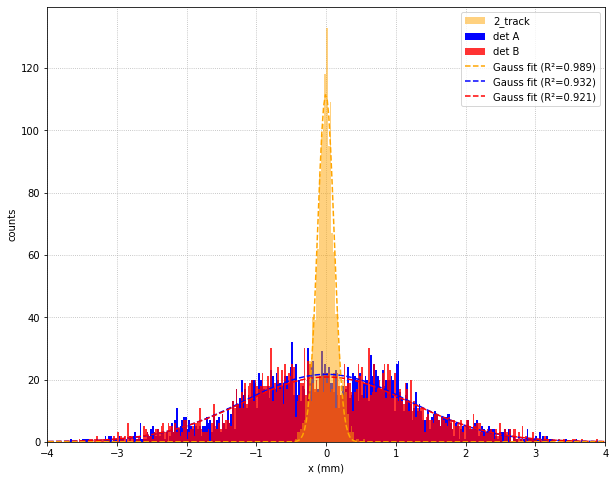

In [7]:
# --- det coinc A & B --- # 
bin_min = -4
bin_max = 4
bin_res = .025
BINS = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1)

plt.figure(figsize = (10,8))
plt.rc('axes', axisbelow=True)
plt.hist(xpos_detA,bins=BINS, label='det A', alpha=.99,color='blue')
plt.hist(xpos_detB,bins=BINS,label='det B', alpha=.8,color='red')
n,x,_ = plt.hist(xpos_coinc,bins=BINS,label='2_track',color='orange', alpha=.5)

bin_centers = 0.5*(x[1:]+x[:-1])

plt.grid(linestyle=':')
plt.xlim([bin_min,bin_max]);
xlim = plt.gca().get_xlim()
plt.xticks(np.linspace(xlim[0],xlim[1],int(abs(xlim[0])+abs(xlim[0])+1)));
plt.xlabel('x (mm)');
plt.ylabel('counts');

#### -------------- Gaussian Fits -------------- ####
# --- det A --- # 

hist, bin_edges = np.histogram(xpos_detA, BINS)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.])
hist_fit_coinc = gauss(bin_centres, *coeff)

FWHM_A = abs(2.355*coeff[2])
RSS = sum((hist-hist_fit_coinc)**2); TSS = sum((hist-np.mean(hist))**2)
R2 = 1-RSS/TSS

plt.plot(bin_centres,hist_fit_coinc,'--',color='blue', label='Gauss fit (R\u00B2=' + str(round(np.sqrt(R2),3)) + ')'  );

print('\ndet A --> x = ' + str(round(coeff[1],5)) + ' mm')
print('\t    --> FWHM = ' + str(round(FWHM_A,4)) + ' mm (R\u00B2 = ' + str(round(np.sqrt(R2),4)) + ')')

# --- det B --- # 
hist, bin_edges = np.histogram(xpos_detB, BINS)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.])
hist_fit_coinc = gauss(bin_centres, *coeff)

FWHM_B = abs(2.355*coeff[2])
RSS = sum((hist-hist_fit_coinc)**2); TSS = sum((hist-np.mean(hist))**2)
R2 = 1-RSS/TSS

plt.plot(bin_centres,hist_fit_coinc,'--',color='red', label='Gauss fit (R\u00B2=' + str(round(np.sqrt(R2),3)) + ')'  );

print('\ndet B --> x = ' + str(round(coeff[1],5)) + ' mm')
print('\t    --> FWHM = ' + str(round(FWHM_B,4)) + ' mm (R\u00B2 = ' + str(round(np.sqrt(R2),4)) + ')')

# --- det Coinc --- # 

hist, bin_edges = np.histogram(xpos_coinc, BINS)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.])
hist_fit_coinc = gauss(bin_centres, *coeff)

FWHM_AB = abs(2.355*coeff[2])
RSS = sum((hist-hist_fit_coinc)**2); TSS = sum((hist-np.mean(hist))**2)
R2 = 1-RSS/TSS

plt.plot(bin_centres,hist_fit_coinc,'--',color='orange', label='Gauss fit (R\u00B2=' + str(round(np.sqrt(R2),3)) + ')'  );

print('\ndet Coinc --> x = ' + str(round(coeff[1],5)) + ' mm')
print('\t    --> FWHM = ' + str(round(FWHM_AB,4)) + ' mm (R\u00B2 = ' + str(round(np.sqrt(R2),4)) + ')')



handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1,5,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]);

# plt.savefig('figname.svg', dpi=300);

# Position reconstruction with random number of neutron captures

In [8]:
# --- Create Shuffle arrays --- #

xpos_det_thick_shuffled = np.copy(xpos_det_thick)
xpos_coinc_shuffled = np.copy(xpos_coinc)

In [9]:
#### GENERATE RANDOM NUMBER OF NEUTRON CAPTURES ####

# --- Shuffle xpos --- #

len_N_captures_array = 23
N_series = int(1e4)
output_array = np.zeros([4,N_series])


N_captures_thick_array = np.zeros(N_series);
N_captures_coinc_array = np.zeros(N_series)

for SEED in range(0,N_series):
    print('seed: ' + str(SEED), end='\r')

    np.random.seed(SEED)
    np.random.shuffle(xpos_det_thick_shuffled)
    np.random.shuffle(xpos_coinc_shuffled)

    
    # Generate random capture number for detector in a log distribution

    
    N_captures_thick = 0;
    while ( (N_captures_thick<10) | (N_captures_thick > len(xpos_det_thick_shuffled)) ):
        N_captures_thick = round(np.random.lognormal(mean=4, sigma=2.5))
   
    N_captures_coinc = 0;
    while ( (N_captures_coinc<10) | (N_captures_coinc > len(xpos_coinc_shuffled)) ):
        N_captures_coinc = round(np.random.lognormal(mean=3.5, sigma=2))    
    
    xpos_det_thick = xpos_det_thick_shuffled[:N_captures_thick]
    xpos_coinc = xpos_coinc_shuffled[:N_captures_coinc]


    #### -------------- Gaussian Fit -------------- ####

    bin_min = -4
    bin_max = 4
    bin_res = .02
    BINS = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1)


    # --- det Thick --- # 

    hist, bin_edges = np.histogram(xpos_det_thick, BINS)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.], maxfev=20000 )
    hist_fit_detThick = gauss(bin_centres, *coeff)

    FWHM_A = abs(2.355*coeff[2])
    RSS = sum((hist-hist_fit_detThick)**2); TSS = sum((hist-np.mean(hist))**2)
    R2 = 1-RSS/TSS

    estimated_x_thick = round(coeff[1],5)
    estimated_FWHM_thick = round(FWHM_A,4)

    # --- det Coinc --- # 

    hist, bin_edges = np.histogram(xpos_coinc, BINS)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=[max(hist), round(np.mean(bin_edges)), 1.],maxfev=20000 )
    hist_fit_coinc = gauss(bin_centres, *coeff)

    FWHM_AB = abs(2.355*coeff[2])
    RSS = sum((hist-hist_fit_coinc)**2); TSS = sum((hist-np.mean(hist))**2)
    R2 = 1-RSS/TSS

    
    estimated_x_coinc = round(coeff[1],5)
    estimated_FWHM_coinc = round(FWHM_AB,4)

    output_array[0,SEED] = estimated_x_thick
    output_array[1,SEED] = estimated_FWHM_thick
    output_array[2,SEED] = estimated_x_coinc
    output_array[3,SEED] = estimated_FWHM_coinc

    N_captures_thick_array[SEED] = N_captures_thick
    N_captures_coinc_array[SEED] = N_captures_coinc


    ## END of seed loop
    

output_Ncaptures = [N_captures_thick_array,N_captures_coinc_array]

output_Ncaptures = np.transpose(output_Ncaptures)  
output_array = np.transpose(output_array)

print('\n DONE')

/Users/duarten/JupyterNBs/NeuThin/NeuThin_venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


seed: 9999
 DONE


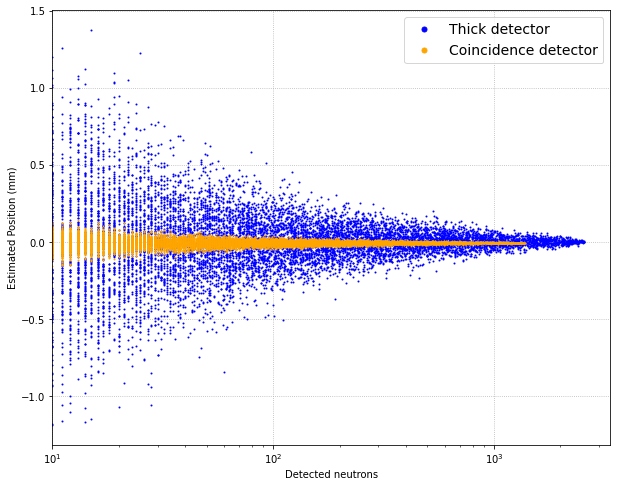

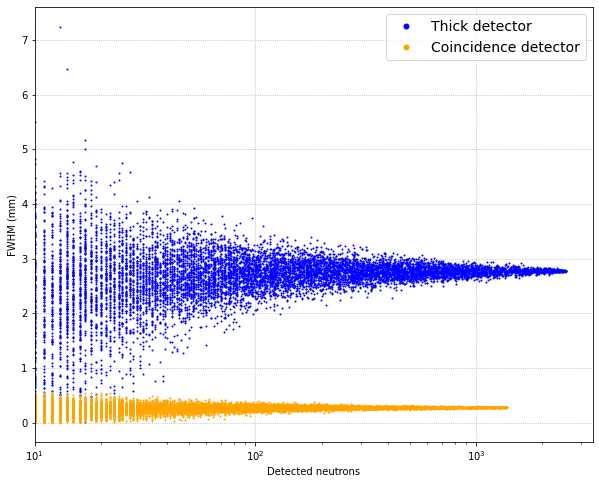

In [10]:
plt.figure(figsize = (10,8))
plt.plot(N_captures_thick_array , output_array[:,0],'.', c='blue', ms = 2); 
plt.plot(N_captures_coinc_array , output_array[:,2],'.', c='orange', ms = 2);

plt.xscale('log'), plt.grid(linestyle=':')
plt.xlabel('Detected neutrons'), plt.ylabel('Estimated Position (mm)')
plt.legend(['Thick detector','Coincidence detector'],loc = "upper right",markerscale=5, fontsize = 14);
plt.xlim(10)


plt.figure(figsize = (10,8))
plt.plot(N_captures_thick_array , output_array[:,1],'.', c='blue', ms = 2);
plt.plot(N_captures_coinc_array , output_array[:,3],'.',c='orange', ms = 2);

plt.xscale('log'), plt.grid(linestyle=':')
plt.xlabel('Detected neutrons'), plt.ylabel('FWHM (mm)')
plt.legend(['Thick detector','Coincidence detector'],loc = "upper right", markerscale=5, fontsize = 14);
plt.xlim(10);

# Plot particles range

In [11]:
# # ----- Stopping Power ----- #
dEdr_detA = detA['dE'].loc[(detA['dr']>0)]/detA['dr'].loc[(detA['dr']>0)]*1e3 # keV/mm
dEdx_detA = detA['dE'].loc[(detA['dx']>0)]/detA['dx'].loc[(detA['dx']>0)]*1e3 # keV/mm

dEdr_detA_alpha = detA_alpha['dE'].loc[(detA_alpha['dr']>0)]/detA_alpha['dr'].loc[(detA_alpha['dr']>0)]*1e3 # keV/mm
dEdx_detA_alpha = detA_alpha['dE'].loc[(detA_alpha['dx']>0)]/detA_alpha['dx'].loc[(detA_alpha['dx']>0)]*1e3 # keV/mm

dEdr_detA_Li = detA_Li['dE'].loc[(detA_Li['dr']>0)]/detA_Li['dr'].loc[(detA_Li['dr']>0)]*1e3 # keV/mm
dEdx_detA_Li = detA_Li['dE'].loc[(detA_Li['dx']>0)]/detA_Li['dx'].loc[(detA_Li['dx']>0)]*1e3 # keV/mm


# ----- Range ----- #
ranges_detThick = np.array(det_thick.iloc[events_det_thick_idx-1]['dr_cum']/1e3)
ranges_detThick = np.append(ranges_detThick[1:],ranges_detThick[0])

ranges_detThick_alpha = np.array(det_thick_alpha.iloc[events_det_thick_alpha_idx-1]['dr_cum']/1e3)
ranges_detThick_alpha = np.append(ranges_detThick_alpha[1:],ranges_detThick_alpha[0])

ranges_detThick_Li = np.array(det_thick_Li.iloc[events_det_thick_Li_idx-1]['dr_cum']/1e3)
ranges_detThick_Li = np.append(ranges_detThick_Li[1:],ranges_detThick_Li[0])


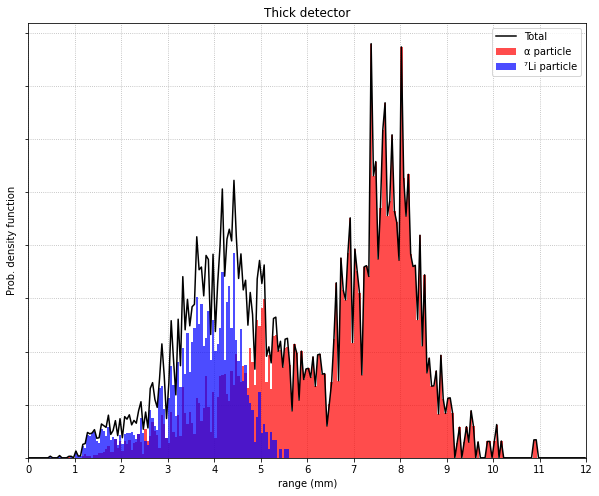

In [12]:
# # ------- Plot Range on same figure -------
bin_min = 0
bin_max = 12
bin_res = .05

plt.figure(figsize = (10,8))
plt.rc('axes', axisbelow=True)
plt.grid(linestyle=':')


ranges_detThick = np.array(det_thick.iloc[events_det_thick_idx-1]['dr_cum']/1e3)
ranges_detThick = np.append(ranges_detThick[1:],ranges_detThick[0])

ranges_detThick_alpha = np.array(det_thick_alpha.iloc[events_det_thick_alpha_idx-1]['dr_cum']/1e3)
ranges_detThick_alpha = np.append(ranges_detThick_alpha[1:],ranges_detThick_alpha[0])

ranges_detThick_Li = np.array(det_thick_Li.iloc[events_det_thick_Li_idx-1]['dr_cum']/1e3)
ranges_detThick_Li = np.append(ranges_detThick_Li[1:],ranges_detThick_Li[0])


plt.hist(ranges_detThick_alpha,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = ranges_detThick_alpha/sum(ranges_detThick),
         color='r',alpha = .7);

plt.hist(ranges_detThick_Li,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = ranges_detThick_Li/sum(ranges_detThick),
         color='b',alpha = .7);

h = np.histogram(ranges_detThick,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = ranges_detThick/sum(ranges_detThick))
plt.plot(h[1][1:]-bin_res/2,h[0],color='k');


ylim = plt.gca().get_ylim()
plt.ylim([0,ylim[1]]);

plt.xlim([bin_min,bin_max]);
xlim = plt.gca().get_xlim()
plt.xticks(np.linspace(xlim[0],xlim[1],int(xlim[1])+1));

plt.gca().axes.yaxis.set_ticklabels([]);
plt.xlabel('range (mm)');
plt.ylabel('Prob. density function');
plt.title('Thick detector');
plt.legend(('Total','\u03B1 particle','\u2077Li particle'));

# plt.savefig('figname.svg', dpi=300)

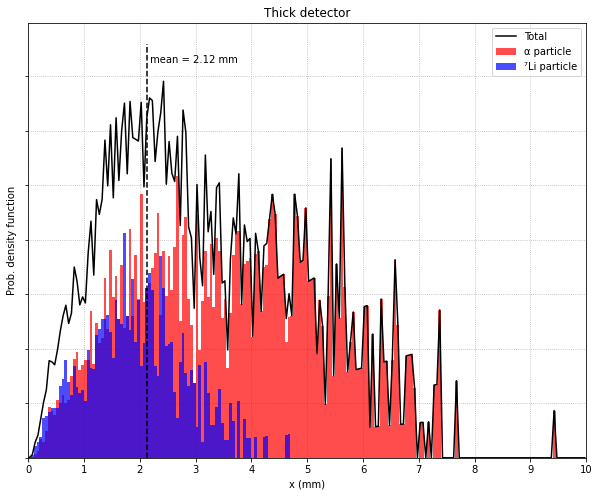

In [13]:
# ------- Plot Range on same figure -------       X coordinate projection
bin_min = 0
bin_max = 10
bin_res = .05

plt.figure(figsize = (10,8))
plt.rc('axes', axisbelow=True)
plt.grid(linestyle=':')


# --- total ---
pos_offset = min(det_thick['xpos']) # compensate min() and max() calculation when track has negative xpos valies

xmin = det_thick.groupby('eventID')['xpos'].min()+pos_offset  #xmin and xmax are always positive
xmax = det_thick.groupby('eventID')['xpos'].max()+pos_offset
xposmax_det_thick = (xmax-xmin)/1e3

h = np.histogram(xposmax_det_thick,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = abs(xposmax_det_thick)/sum(abs(xposmax_det_thick)))
plt.plot(h[1][1:]-bin_res/2,h[0],color='k');


# --- alpha ---
xmin = det_thick.loc[(det_thick['PID']=='alpha')].groupby('eventID')['xpos'].min()+pos_offset  #xmin and xmax are always positive
xmax = det_thick.loc[(det_thick['PID']=='alpha')].groupby('eventID')['xpos'].max()+pos_offset
xposmax_det_thick_alpha = (xmax-xmin)/1e3

plt.hist(xposmax_det_thick_alpha,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = abs(xposmax_det_thick_alpha)/sum(abs(xposmax_det_thick)),
         color='r',alpha = .7);

# --- Li ---
xmin = det_thick.loc[(det_thick['PID']=='Li7')].groupby('eventID')['xpos'].min()+pos_offset  #xmin and xmax are always positive
xmax = det_thick.loc[(det_thick['PID']=='Li7')].groupby('eventID')['xpos'].max()+pos_offset
xposmax_det_thick_Li = (xmax-xmin)/1e3

plt.hist(xposmax_det_thick_Li,
         bins = np.linspace(bin_min,bin_max,int((bin_max-bin_min)/bin_res)+1),
         weights = abs(xposmax_det_thick_Li)/sum(abs(xposmax_det_thick)),
         color='b',alpha = .7);



plt.gca().axes.yaxis.set_ticklabels([]);
plt.xlabel('x (mm)');
plt.ylabel('Prob. density function');
plt.title('Thick detector');
plt.legend(('Total','\u03B1 particle','\u2077Li particle'));


anotation_str = ' mean = ' + str(round(np.average(xposmax_det_thick),2)) + ' mm'
plt.annotate(anotation_str,(np.average(xposmax_det_thick),max(h[0])*1.05));
plt.plot([np.average(xposmax_det_thick), np.average(xposmax_det_thick)] , [0,max(h[0])*1.1],'k--')



ylim = plt.gca().get_ylim()
plt.ylim([0,ylim[1]]);
plt.xlim([bin_min,bin_max]);
xlim = plt.gca().get_xlim()
plt.xticks(np.linspace(xlim[0],xlim[1],int(xlim[1])+1));

# plt.savefig('figname.svg', dpi=300)

# Visualize tracks and dE/dx

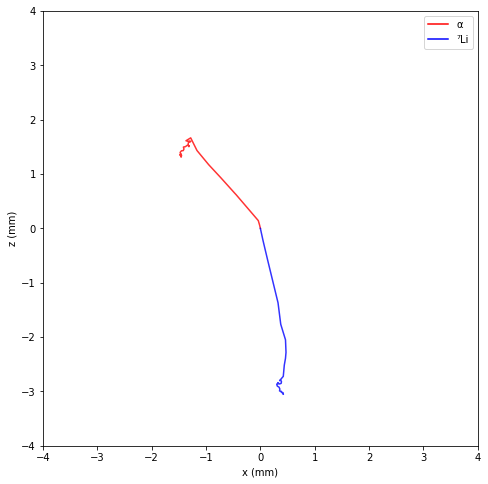

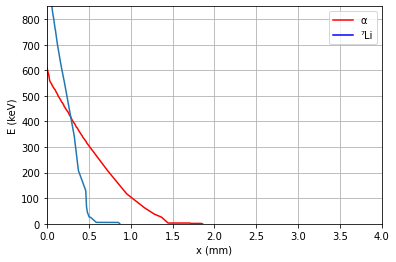

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_box_aspect(1)


N = 1

for N in range(N,N+1):
    print('N = ' + str(N),end="\r")
    xTrack_alpha = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['xpos'];
    zTrack_alpha = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['zpos'];
    xTrack_Li7 = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['xpos'];
    zTrack_Li7 = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['zpos'];

    plt.plot(xTrack_alpha/1e3,zTrack_alpha/1e3,'r', alpha = .8, markersize = .1);
    plt.plot(xTrack_Li7/1e3,zTrack_Li7/1e3, 'b', alpha = .8, markersize = .1);
    
    
plt.xlabel('x (mm)');
plt.ylabel('z (mm)');
plt.ylim(-4,4);  plt.yticks(range(-4, 4+1, 1))
plt.xlim(-4,4); plt.xticks(range(-4, 4+1, 1))

red_line = mlines.Line2D([], [], color='red', label='\u03B1');
blue_line = mlines.Line2D([], [], color='blue', label='\u2077Li');
plt.legend(handles=[red_line,blue_line]);

# plt.savefig('figname.svg', dpi=300)

E = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['E']
dE = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['dE']
dx = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['dx']
xpos = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['xpos']/1e3
dx_cum = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='alpha']['dx_cum']/1e3

plt.figure()
plt.plot(dx_cum,E,'r')

E = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['E']
dE = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['dE']
dx = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['dx']
xpos = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['xpos']/1e3
dx_cum = detCoinc.loc[detCoinc['eventID'].isin(events_coinc[N-1:N])].loc[detCoinc['PID']=='Li7']['dx_cum']/1e3

# plt.figure()
plt.plot(dx_cum,E)
plt.xlabel('x (mm)');
plt.ylabel('E (keV)');
plt.xlim(0,4);
plt.ylim(0,850);
plt.legend(handles=[red_line,blue_line]);
plt.grid()

# plt.savefig('figname.svg', dpi=300)
